In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import os

# Pour les figures plus grandes
plt.rcParams["figure.figsize"] = (8, 5)

# Dossier où sauver les images pour le rapport
OUTPUT_DIR = "resultats_tp_seqvid"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def show_image_bgr(bgr, title=None):
    """Affiche une image BGR (OpenCV) dans le notebook."""
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.figure()
    if title is not None:
        plt.title(title)
    plt.imshow(rgb)
    plt.axis("off")
    plt.show()

def save_image_bgr(bgr, filename):
    """Sauvegarde une image BGR sur disque (pour le rapport)."""
    path = os.path.join(OUTPUT_DIR, filename)
    cv2.imwrite(path, bgr)
    print("Image sauvegardée :", path)


Nombre de coins détectés : 300


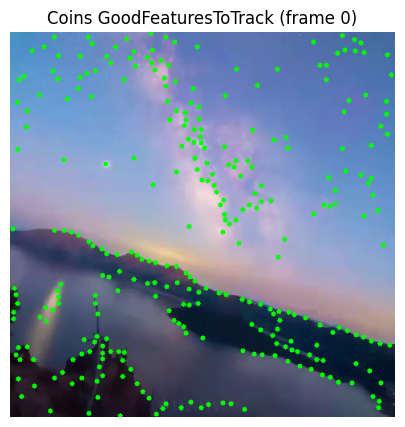

Image sauvegardée : resultats_tp_seqvid/gftt_frame0.png


In [2]:
video_path = "/kaggle/input/skytimelapse/planet.mp4"   
cap = cv2.VideoCapture(video_path)

ret, first_frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("Impossible de lire la vidéo. Vérifie le chemin.")

gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Paramètres GFTT (à faire varier pour le TP)
maxCorners   = 300      # nombre max de points
qualityLevel = 0.01     # 0.01 = garder les meilleurs coins
minDistance  = 7        # distance minimum entre deux coins
blockSize    = 7        # taille du voisinage pour le gradient
useHarris    = False    # True -> détecteur de Harris, False -> Shi-Tomasi

corners = cv2.goodFeaturesToTrack(
    gray,
    maxCorners=maxCorners,
    qualityLevel=qualityLevel,
    minDistance=minDistance,
    blockSize=blockSize,
    useHarrisDetector=useHarris
)

print("Nombre de coins détectés :", len(corners))

vis_corners = first_frame.copy()
for c in corners:
    x, y = c.ravel()
    cv2.circle(vis_corners, (int(x), int(y)), 3, (0, 255, 0), -1)

show_image_bgr(vis_corners, "Coins GoodFeaturesToTrack (frame 0)")
save_image_bgr(vis_corners, "gftt_frame0.png")


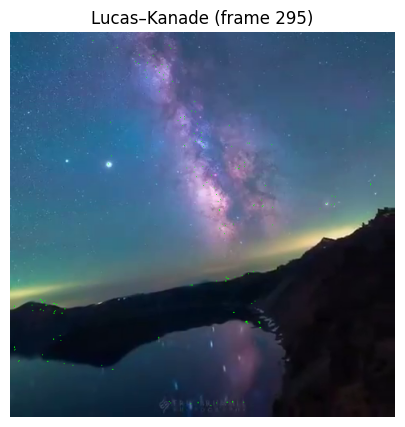

Image sauvegardée : resultats_tp_seqvid/lk_frame_0295.png


In [3]:
def run_lucas_kanade(video_path,
                     max_frames=300,
                     draw_step=5,
                     save_examples=True):
    cap = cv2.VideoCapture(video_path)

    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        raise RuntimeError("Impossible de lire la vidéo.")

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # --- Détection initiale de coins ---
    prev_points = cv2.goodFeaturesToTrack(
        prev_gray,
        maxCorners=maxCorners,
        qualityLevel=qualityLevel,
        minDistance=minDistance,
        blockSize=blockSize,
        useHarrisDetector=useHarris
    )

    # Paramètres Lucas–Kanade
    lk_params = dict(
        winSize  = (21, 21),
        maxLevel = 3,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                    30, 0.01)
    )

    frame_idx = 0
    example_id = 0

    while cap.isOpened() and frame_idx < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        next_points, status, err = cv2.calcOpticalFlowPyrLK(
            prev_gray, gray, prev_points, None, **lk_params
        )

        if next_points is None:
            print("Plus de points à suivre.")
            break

        good_new = next_points[status == 1]
        good_old = prev_points[status == 1]

        vis = frame.copy()

        # On ne dessine que toutes les draw_step frames pour pas saturer l'affichage
        for new, old in zip(good_new, good_old):
            x_new, y_new = new.ravel()
            x_old, y_old = old.ravel()
            cv2.arrowedLine(
                vis,
                (int(x_old), int(y_old)),
                (int(x_new), int(y_new)),
                (0, 255, 0),
                1,
                tipLength=0.3
            )

        if frame_idx % draw_step == 0:
            clear_output(wait=True)
            show_image_bgr(vis, f"Lucas–Kanade (frame {frame_idx})")

            if save_examples:
                save_image_bgr(vis, f"lk_frame_{frame_idx:04d}.png")
                example_id += 1

        prev_gray = gray.copy()
        prev_points = good_new.reshape(-1, 1, 2)
        frame_idx += 1

    cap.release()

run_lucas_kanade(video_path)


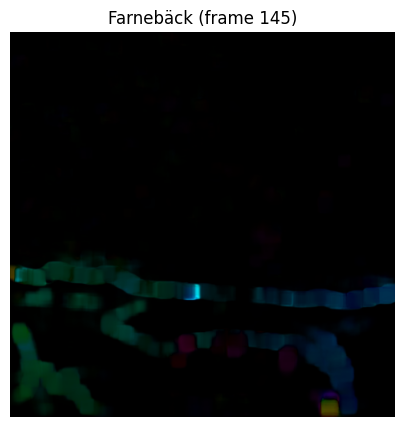

Image sauvegardée : resultats_tp_seqvid/farneback_frame_0145.png


In [4]:
def run_farneback(video_path,
                  max_frames=150,
                  draw_step=5,
                  save_examples=True):
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        raise RuntimeError("Impossible de lire la vidéo.")

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    hsv = np.zeros_like(prev_frame)
    hsv[..., 1] = 255  # saturation max

    frame_idx = 0

    while cap.isOpened() and frame_idx < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, gray,
            None,
            pyr_scale=0.5,   # échelle de la pyramide
            levels=3,        # nb de niveaux
            winsize=15,      # taille fenêtre moyenne locale
            iterations=3,    # nb d'itérations par niveau
            poly_n=5,        # taille du voisinage pour modèle polynomial
            poly_sigma=1.2,  # écart-type de la gaussienne
            flags=0
        )

        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        hsv[..., 0] = ang * 180 / np.pi / 2
        hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        if frame_idx % draw_step == 0:
            clear_output(wait=True)
            show_image_bgr(rgb, f"Farnebäck (frame {frame_idx})")

            if save_examples:
                save_image_bgr(rgb, f"farneback_frame_{frame_idx:04d}.png")

        prev_gray = gray
        frame_idx += 1

    cap.release()

run_farneback(video_path)
